<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/TSAI_EVA4_S5_Model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 5:  Use image augmentation, GAP layer and optimized steps LRstep

#Target : 
- Lesser parameters around 10K
- Test Accuracy ~99%
- ~15 Epochs 

#Results: 
- Parameters used : 11296
- Train Accuracy: 98.31%
- Test Accuracy : 98.72%

#Analysis - Observation :
-  Require more parameters to achieve the target or Less number of parameters requires more epochs to reach higher accuracy


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [0]:
import torch.nn.functional as F
dropout_value = 0.2
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24, RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF=5, step=2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 12, RF=9, step=2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6, RF=13, step=2
        # self.convblock6 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),            
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1, RF= 23, step=2

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        # x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
           Dropout-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           4,608
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    #     loss, correct, len(train_loader.dataset),
    #     100. * correct / len(train_loader.dataset)))
    

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=2.316941261291504 Batch_id=0 Accuracy=9.38:   0%|          | 1/938 [00:00<02:18,  6.75it/s]

EPOCH: 0


Loss=0.19354653358459473 Batch_id=937 Accuracy=88.66: 100%|██████████| 938/938 [02:02<00:00,  7.67it/s]
Loss=0.26937335729599 Batch_id=0 Accuracy=92.19:   0%|          | 1/938 [00:00<02:05,  7.49it/s]


Test set: Average loss: 0.1229, Accuracy: 9659/10000 (96.59%)

EPOCH: 1


Loss=0.2305106520652771 Batch_id=937 Accuracy=96.50: 100%|██████████| 938/938 [02:00<00:00,  7.78it/s]
Loss=0.07412976026535034 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<02:00,  7.75it/s]


Test set: Average loss: 0.0682, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.03777097910642624 Batch_id=937 Accuracy=97.15: 100%|██████████| 938/938 [01:59<00:00,  7.82it/s]
Loss=0.1486348956823349 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<02:01,  7.73it/s]


Test set: Average loss: 0.0631, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


Loss=0.0314340703189373 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [01:58<00:00,  7.89it/s]
Loss=0.03157230466604233 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:00,  7.77it/s]


Test set: Average loss: 0.0605, Accuracy: 9815/10000 (98.15%)

EPOCH: 4


Loss=0.0199640654027462 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [01:59<00:00,  7.84it/s]
Loss=0.03164156153798103 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:09,  7.26it/s]


Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.004156508017331362 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [02:00<00:00,  7.81it/s]
Loss=0.023892279714345932 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:09,  7.26it/s]


Test set: Average loss: 0.0459, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.04702309891581535 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [01:59<00:00,  7.84it/s]
Loss=0.11263176798820496 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<02:03,  7.61it/s]


Test set: Average loss: 0.0421, Accuracy: 9869/10000 (98.69%)

EPOCH: 7


Loss=0.028588639572262764 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [02:00<00:00,  7.80it/s]
Loss=0.06939087808132172 Batch_id=0 Accuracy=93.75:   0%|          | 1/938 [00:00<01:57,  7.97it/s]


Test set: Average loss: 0.0410, Accuracy: 9869/10000 (98.69%)

EPOCH: 8


Loss=0.05349409207701683 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [01:59<00:00,  7.83it/s]
Loss=0.022051412612199783 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:02,  7.67it/s]


Test set: Average loss: 0.0393, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.0627303496003151 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [02:00<00:00,  7.75it/s]
Loss=0.01134201418608427 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:00,  7.79it/s]


Test set: Average loss: 0.0399, Accuracy: 9875/10000 (98.75%)

EPOCH: 10


Loss=0.0767325758934021 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [02:00<00:00,  7.81it/s]
Loss=0.012031312100589275 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:01,  7.74it/s]


Test set: Average loss: 0.0387, Accuracy: 9878/10000 (98.78%)

EPOCH: 11


Loss=0.002905621426180005 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [01:58<00:00,  7.91it/s]
Loss=0.01597071811556816 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:02,  7.63it/s]


Test set: Average loss: 0.0393, Accuracy: 9877/10000 (98.77%)

EPOCH: 12


Loss=0.008649252355098724 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [01:59<00:00,  7.85it/s]
Loss=0.0907500684261322 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:59,  7.84it/s]


Test set: Average loss: 0.0389, Accuracy: 9882/10000 (98.82%)

EPOCH: 13


Loss=0.011557050980627537 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [01:58<00:00,  7.92it/s]
Loss=0.06205037236213684 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:58,  7.89it/s]


Test set: Average loss: 0.0380, Accuracy: 9877/10000 (98.77%)

EPOCH: 14


Loss=0.11215373128652573 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [01:59<00:00,  7.85it/s]



Test set: Average loss: 0.0401, Accuracy: 9872/10000 (98.72%)



Text(0.5, 1.0, 'Test Accuracy')

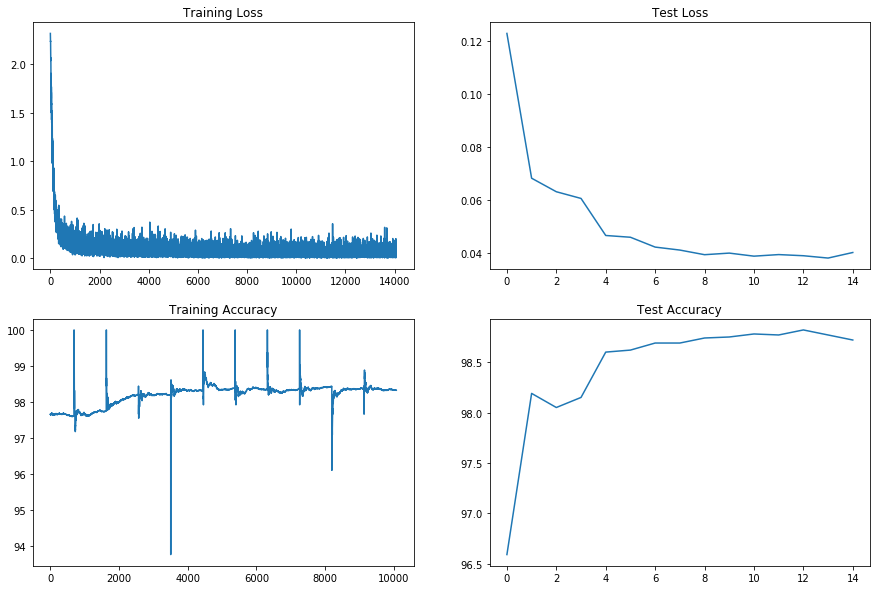

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")